# Writing WCS info to FF fits files

Goal of this notebook is to write a world coordinate system to an 'FF-file', the FITS file format used by Global Meteor Network.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS, Sip
from astropy.wcs.utils import fit_wcs_from_points
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table
import json

In [2]:
import pyproj

In [3]:
import RMS.ConfigReader as cr

In [4]:
import json

Read the manually selected astrometry calibration stars from the 'platepar' file.

In [5]:
t = Table(names=["x", "y", "ra", "dec"])

with open(
    "RU0001/platepar_cmn2010.cal"
) as platepar:
    my_platepar = json.load(platepar)
    star_list = my_platepar["star_list"]
    for star in star_list:
        t.add_row(star[1:3] + star[4:6])

In [6]:
t

x,y,ra,dec
float64,float64,float64,float64
592.8053569106817,414.4733678594917,342.41936859811,66.1998674347798
657.2550182447939,218.21166068936557,322.165055708522,70.5607206921572
889.3257941666302,248.3954687432386,311.323181316809,61.8423054857646
1044.732186351117,215.97312017795733,303.349924875647,56.5680737323416
755.0006610329021,42.87045005303109,297.044140294351,70.2681026643958
572.9207513625583,22.184918167712986,302.22251415811,77.7115269295082
360.19788632752505,46.20190694324685,343.608342378519,84.3462788804618
388.9906500995946,209.6672648826769,354.835823347857,77.6331008548773
155.18272584623813,554.7979763401077,28.599179237149,63.6700205880048


Read the data, and overplot the calibration stars.

In [7]:
fbfits = fits.open("RU0001/FF_RU0001_20190427_210639_501_0363008.fits")

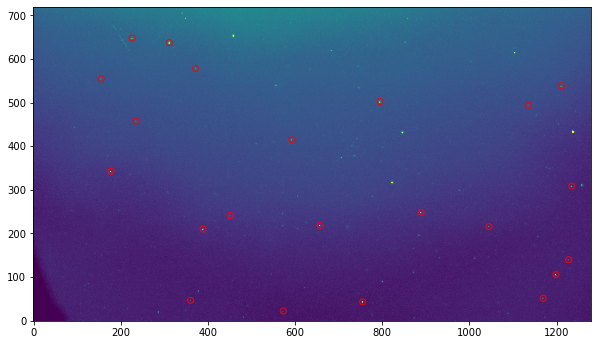

In [8]:
fig, ax0 = plt.subplots(1, figsize=(10, 10))
ax0.imshow(fbfits[1].data, origin="lower")
ax0.scatter(t["x"], t["y"], marker="o", facecolors="None", color="r");

In [9]:
ymax, xmax = fbfits[1].data.shape

In [10]:
x0, y0 = xmax / 2, ymax / 2

In [11]:
config = cr.loadConfigFromDirectory(".", "RU0001/")

Loading config file: /Users/dijkema/opt/asm/notebooks/RU0001/.config


In [12]:
# Create initial WCS
w0 = WCS(naxis=2)
w0.wcs.ctype = ["RA---ZEA", "DEC--ZEA"]
w0.wcs.cd = [[-config.fov_w / xmax, 0], [0, -config.fov_h / ymax]]
w0.wcs.crpix = [x0, y0]

In [13]:
w = fit_wcs_from_points(
    (t["x"], t["y"]),
    SkyCoord(ra=t["ra"] * u.deg, dec=t["dec"] * u.deg),
    proj_point='center', #SkyCoord(ra=ra0*u.deg, dec=dec0*u.deg),
    sip_degree=3,
    projection=w0
)

In [14]:
t["xp"], t["yp"] = w.all_world2pix(np.stack((t["ra"], t["dec"]), axis=-1), 1).T

In [15]:
t["rap"], t["decp"] = w.all_pix2world(np.stack((t["x"], t["y"]), axis=1), 1).T

This shows that forward and backward transforms work.

In [16]:
wcshdr = w.to_header(relax=True)

In [17]:
for hdrnum in range(1, 5):
    for key in wcshdr:
        fbfits[hdrnum].header.append((key, wcshdr[key]))

In [18]:
fbfits.writeto(
    "RU0001/FF_RU0001_20190427_210639_501_0363008-wcs.fits", overwrite=True,
)

Plot distortion corrections.

In [19]:
p = np.meshgrid(np.linspace(0, xmax, 16), np.linspace(0, ymax, 16))
x, y = p[0].ravel(), p[1].ravel()

In [20]:
xd, yd = w.sip_pix2foc(x, y, 1)

In [21]:
w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---ZEA-SIP'  'DEC--ZEA-SIP'  
CRVAL : 356.4400647577242  64.20214305829919  
CRPIX : 487.58864013203055  519.9613023676765  
CD1_1 CD1_2  : -0.03919733215129473  0.014108927594142912  
CD2_1 CD2_2  : -0.013716125534334852  -0.039180620314554555  
NAXIS : 1079.421140826846  625.577383237019

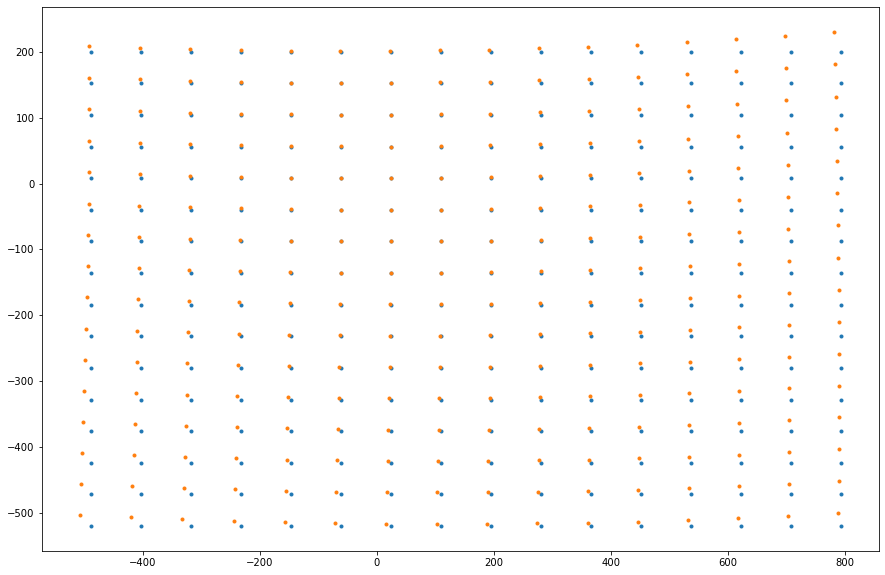

In [22]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(x - w.wcs.crpix[0], y - w.wcs.crpix[1], ".")
ax.plot(xd, yd, ".");